![MIoT_GDPI](img/MIOT_GDPI_header.png)

# Unidad 05 - Introducción a las Redes Neuronales Recurrentes (RNN)
Típicamente, las plantas industriales cuentan con líneas de producción secuenciales en las que los procesos son altamente no lineales y tienen grandes dependencias temporales. Como consecuencia, los modelos predictivos que no tienen en cuenta el tiempo, suelen ser poco apropiados. En esta práctica introduciremos las Redes Neuronales Recurrentes (RNN) simples como sistemas capaces de modelar procesos en los que se tiene en cuenta el histórico de las observaciones para poder predecir con precisión. 



La mayor parte del contenido de este Notebook se dedica a explicar la adaptación de los datos y el uso del API Keras para generar y utilizar RNNs. Es crucial que dediquéis tiempo a leer y comprender el material, en lugar de simplemente ejecutar el código. Os invitamos a experimentar modificando y variando el código proporcionado para que podáis explorar las distintas opciones y profundizar en cada uno de los conceptos mostrados.



**Importante**: El Notebook contiene varios ejercicios sencillos que deberéis desarrollar durante la clase y enviarlos por el aula virtual del curso a través de la tarea correspondiente.




## Referencias útiles para la práctica

1. [Documentación oficial](https://www.tensorflow.org/learn?hl=es-419) de Tensorflow
2. [Guías](https://keras.io/guides/) de Keras
3. [Vídeo](https://www.youtube.com/watch?v=AsNTP8Kwu80 ) intuitivo y ameno sobre las RNNs
4. A. Bosch Rué, J. Casas-Roma, T. Lozano Bagén (2019): [Deep learning : principios y fundamentos](https://elibro-net.ezbusc.usc.gal/es/ereader/busc/126167/).




## 1. Redes Neuronales Recurrentes
En el ámbito de la optimización y el análisis predictivo dentro de las líneas de producción industrial, nos encontramos a menudo con procesos que no son estáticos, sino que se desarrollan a lo largo del tiempo, donde cada paso o estación influye en los siguientes. La naturaleza secuencial de estas operaciones es fundamental: el estado actual de un producto o del proceso mismo depende intrínsecamente de su historia previa. Si intentamos aplicar modelos de aprendizaje automático que tratan cada punto de datos o cada instante como una observación independiente, sin tener en cuenta el orden o la dependencia temporal (como haríamos con modelos tradicionales que asumen independencia y distribución idéntica), estaremos ignorando información crucial. Estos modelos no pueden "recordar" lo que ocurrió antes, lo que los hace inadecuados para capturar patrones que se despliegan a lo largo de la secuencia de producción. Es aquí donde las Redes Neuronales Recurrentes (RNNs) cobran relevancia.

Su arquitectura inherente, diseñada para procesar secuencias, les permite mantener un estado interno que actúa como una memoria, incorporando información de pasos temporales anteriores para influir en el procesamiento del paso actual. Esta capacidad de aprender y utilizar el contexto histórico las convierte en la herramienta perfecta para modelar las complejas dinámicas temporales de una línea de producción secuencial, permitiéndonos abordar tareas como la detección temprana de fallos que se desarrollan con el tiempo, la predicción de desvíos en variables de calidad teniendo en cuenta las observaciones históricas  o la optimización de parámetros en tiempo real considerando el impacto de ajustes pasados.


### 1.1 Concepto de recurrencia

Hasta ahora, en todas las ANN que habéis visto la información fluye siempre en una única dirección: desde las neuronas de entrada a las neuronas de salida. Son las ANN conocidas como *feedforward*, pero, en realidad, nada impide que haya conexiones desde una capa posterior a una anterior. Empleando esta particularidad podemos hacer que cuando la ANN procese una observación concreta, utilice también información que generó la red en un paso anterior. 


In [1]:

# Importaciones generales
try:
    import pandas as pd
except ImportError as err:
    !pip install pandas
    import pandas as pd

try:
    import numpy as np
except ImportError as err:
    !pip install numpy
    import numpy as np


try:
    import seaborn as sns
except ImportError as err:
    !pip install seaborn
    import seaborn as sns



try:
    import matplotlib.pyplot as plt
except ImportError as err:
    !pip install matplotlib
    import matplotlib.pyplot as plt

import os

# Asegurarnos de usar Keras 3 con backend TensorFlow
# Es necesario hacerlo antes de cargar Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importaciones de Keras y TensorFlow
try:
    import keras
except ImportError as err:
    !pip install keras
    import keras

try:
    import tensorflow as tf 
except ImportError as err:
    !pip install tensorflow
    import tensorflow as tf 



# Importaciones de Scikit-learn
#Solo para facilitarnos el uso de algunas operaciones típicas
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Configuraciones para visualización. No es necesario
plt.style.use('seaborn-v0_8-whitegrid') # Estilo de gráficos
sns.set_palette('viridis') # Paleta de colores


# Verificación de versiones
#Existen diferentes versiones y compatibilidades. Es importantes saber lo que estamos ejecutando
#Para estos ejemplos queremos ejecutar el API de Keras3 (standalone) y tensorflo3>2.16
print(f"Versión de Keras: {keras.__version__}")
print(f"Backend de Keras: {keras.backend.backend()}")
print(f"Versión de TensorFlow: {tf.__version__}")



# Verificar si TensorFlow puede usar GPU en nuestro sistema (opcional, pero bueno saberlo)
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"GPU disponible: {gpu_devices}")
else:
    print("GPU no encontrada, se usará CPU.")


#Establecemos una semilla para todos los procesos en los que lo necesitemos
SEED=1234

print(f"la semilla que emplearemos para todos los procesos pseudoaleatorios es:{SEED}")

2025-05-09 10:10:31.563435: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 10:10:31.691011: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-09 10:10:31.771097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746778231.833381   12249 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746778231.853182   12249 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746778232.045273   12249 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Versión de Keras: 3.9.2
Backend de Keras: tensorflow
Versión de TensorFlow: 2.19.0
GPU no encontrada, se usará CPU.
la semilla que emplearemos para todos los procesos pseudoaleatorios es:1234


2025-05-09 10:10:34.488297: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


#### Dataset

Vamos a crear un dataset sintético  que imite una fábrica con una línea de producción  secuencial dividida en **5 secciones**. 

1.  **Sensores en cada sección:**
    * En cada sección, una máquina realiza una operación (ej: apretar un tornillo, calentar una pieza, etc.) y un sensor mide un parámetro clave de esa operación (ej: las revoluciones por minuto de un motor, la temperatura aplicada, etc.). Tendremos 5 series de datos, una por cada sensor de sección.
    * Cada sección puede influir en la siguiente; por ejemplo, si una máquina en la sección 2 trabajó muy rápido, la sección 3 podría tener que ajustarse ligeramente.

2.  **Variable de Calidad Final:**
    * Al final de toda la línea, se inspecciona el producto y se mide una **variable de calidad** (ej: la resistencia de una soldadura, la humedad interna, el perfil de densidad, etc).
    * Esta calidad final **NO depende solo de la última operación**. Más bien, es el resultado de una *combinación* de cómo se aplicaron los procesos previos en las diferentes secciones cuando ese producto pasó por ellas.
        * Por ejemplo, la calidad podría depender mucho de lo que hizo la máquina de la sección 1 cuando el producto estuvo allí (hace 5 "pasos de tiempo"), un poco de la sección 2 (hace 3 "pasos de tiempo"), y así sucesivamente. Algunas secciones podrían no influir nada en esta variable de calidad particular.
    * Esta relación entre las operaciones pasadas y la calidad final no es simple (es no-lineal) y tiene algo de "ruido" o variabilidad, como en la vida real.

3.  **El Reto para la Red Neuronal:**
    * Nuestro DataFrame mostrará, para cada producto, las lecturas actuales de los 5 sensores y su calidad final.
    * La Red Neuronal Recurrente (RNN) recibirá secuencias de las lecturas de los sensores de varios productos consecutivos. Su tarea será **aprender y descubrir por sí misma cómo esas lecturas pasadas (y de qué secciones específicas y con qué "retraso") afectan a la calidad del siguiente producto**, sin que le digamos explícitamente "fíjate en la sección 1 de hace 5 pasos".

Este dataset nos permitirá simular un problema realista donde es necesario analizar secuencias temporales para predecir un resultado futuro que tiene dependencias complejas con el pasado.

In [114]:
# ## Generación de Datos Sintéticos (Línea de Producción Secuencial)

N_SAMPLES_FINAL = 5000 # Número de muestras finales en nuestro dataset
N_SECTIONS = 5 #secciones de nuestra línea de producción
SEQUENCE_LENGTH = 5 # Usaremos secuencias de 5 timesteps para predecir el siguiente.

# Parámetros para la generación de datos de sensores por sección
# Lags (en pasos de tiempp para la contribución de cada sección a la calidad final.
# L_s = k significa que el valor del sensor de la sección 's' hace k observaciones afectó la calidad del producto actual.
# Ejemplo: L_s = 1 significa que P_{s, t-1} afecta a Q_t.
section_lags = np.array([5, 4, 3, 1, 1]) # Lags para S1, S2, S3, S4, S5 respectivamente

L_max = np.max(section_lags) if len(section_lags) > 0 else 0

# Necesitamos generar más datos al principio para acomodar los retardos máximos.
N_RAW_SAMPLES = N_SAMPLES_FINAL + L_max

# Inicializar arrays para los valores de los sensores
P_raw = np.zeros((N_SECTIONS, N_RAW_SAMPLES))
time_raw = np.arange(N_RAW_SAMPLES)

# Sección 1 (S1) - Comportamiento base
P_raw[0, :] = 100 + 10 * np.sin(time_raw / 50) + 5 * np.cos(time_raw / 20) + np.random.randn(N_RAW_SAMPLES) * 2

# Secciones 2 a 5 (S2-S5) - Influenciadas por la sección anterior
# Coeficientes de influencia de la sección anterior (pequeños)
alpha_influence = [0.15, 0.2, 0.1, 0.05] # Para S2 por S1, S3 por S2, etc.

# Parámetros base para cada sección (amplitud, frecuencia, offset, ruido)
base_params_amplitude = [8, 12, 7, 10]
base_params_period = [60, 40, 70, 45]
base_params_offset = [80, 120, 90, 110]
base_params_noise_std = [1.5, 2, 1, 1.8]


for s in range(1, N_SECTIONS): # Para S2, S3, S4, S5
    influence_term = alpha_influence[s-1] * P_raw[s-1, :]
    base_behavior = (base_params_amplitude[s-1] * np.sin(time_raw / base_params_period[s-1]) +
                     base_params_offset[s-1] +
                     np.random.randn(N_RAW_SAMPLES) * base_params_noise_std[s-1])
    P_raw[s, :] = influence_term + base_behavior




# Nos aseguramos que los parámetros estén en rangos plausibles (clipping)
P_raw[0, :] = np.clip(P_raw[0, :], 70, 130) # S1
P_raw[1, :] = np.clip(P_raw[1, :], 60, 150) # S2
P_raw[2, :] = np.clip(P_raw[2, :], 70, 160) # S3
P_raw[3, :] = np.clip(P_raw[3, :], 80, 140) # S4
P_raw[4, :] = np.clip(P_raw[4, :], 90, 160) # S5



# Generación de la Variable de Calidad Final (Q_t)
# Q_t = f(P_{1,t-L1}, P_{2,t-L2}, P_{3,t-L3}, P_{4,t-L4}, P_{5,t-L5}) + global_noise_t
# Los pesos (w_s) indican la contribución de cada sección. Algunos pueden ser cero.
quality_weights = np.array([0, 0.2, 0., 0.0, 0.8]) # w1, w2, w3, w4 (no contribuye), w5



Q_raw = np.zeros(N_RAW_SAMPLES)
base_quality_offset = 60  #valor base de la variable de calidad al que se le añade el efecto de las otras secciones
quality_noise_std = 3




for t in range(L_max, N_RAW_SAMPLES):
    term1 = quality_weights[0] * np.sin(P_raw[0, t - section_lags[0]] / 20) * 10
    term2 = quality_weights[1] * (P_raw[1, t - section_lags[1]] / 100)**2 * 30
    term3 = quality_weights[2] * np.tanh((P_raw[2, t - section_lags[2]] - np.mean(P_raw[2,:])) / 15) * 20
    term4 = quality_weights[3] * (P_raw[3, t - section_lags[3]] / 100) # Este término será cero
    term5 = quality_weights[4] * (P_raw[4, t - section_lags[4]] / 120) * (P_raw[0, t - section_lags[0]] / 120) * 25
    #Q_raw[t] = base_quality_offset
    #for i in range(N_SECTIONS):
    #    Q_raw[t] += quality_weights[i] * P_raw[0, t - section_lags[i]]
    
    #Q_raw[t] +=  np.random.randn() 
    

    #Q_raw[t] = base_quality_offset + term1 + term2 + term3 + term4 + term5 + (np.random.randn() * quality_noise_std)
    Q_raw[t] = base_quality_offset + term1 + term2 + term3 + term4 + term5 


df_cols = {}
for s in range(N_SECTIONS):
    df_cols[f'Seccion_{s+1}'] = P_raw[s, L_max:]
df_cols['Quality'] = Q_raw[L_max:]

data_df = pd.DataFrame(df_cols)

print("Primeras filas del dataset generado:")
print(data_df.head())
print(f"\nForma del dataset: {data_df.shape}")

    

Primeras filas del dataset generado:
    Seccion_1  Seccion_2   Seccion_3   Seccion_4   Seccion_5    Quality
0  104.507339  94.259838  141.371658  103.507709  115.856788  82.963624
1  101.719647  98.229081  142.375100  103.961979  118.133980  82.539959
2  106.847021  99.095839  145.458222  105.519956  118.115803  83.239067
3  105.090013  96.179362  142.679305  106.555941  119.080845  82.532208
4  109.195129  97.360088  142.249513  106.152772  118.442612  82.603137

Forma del dataset: (5000, 6)


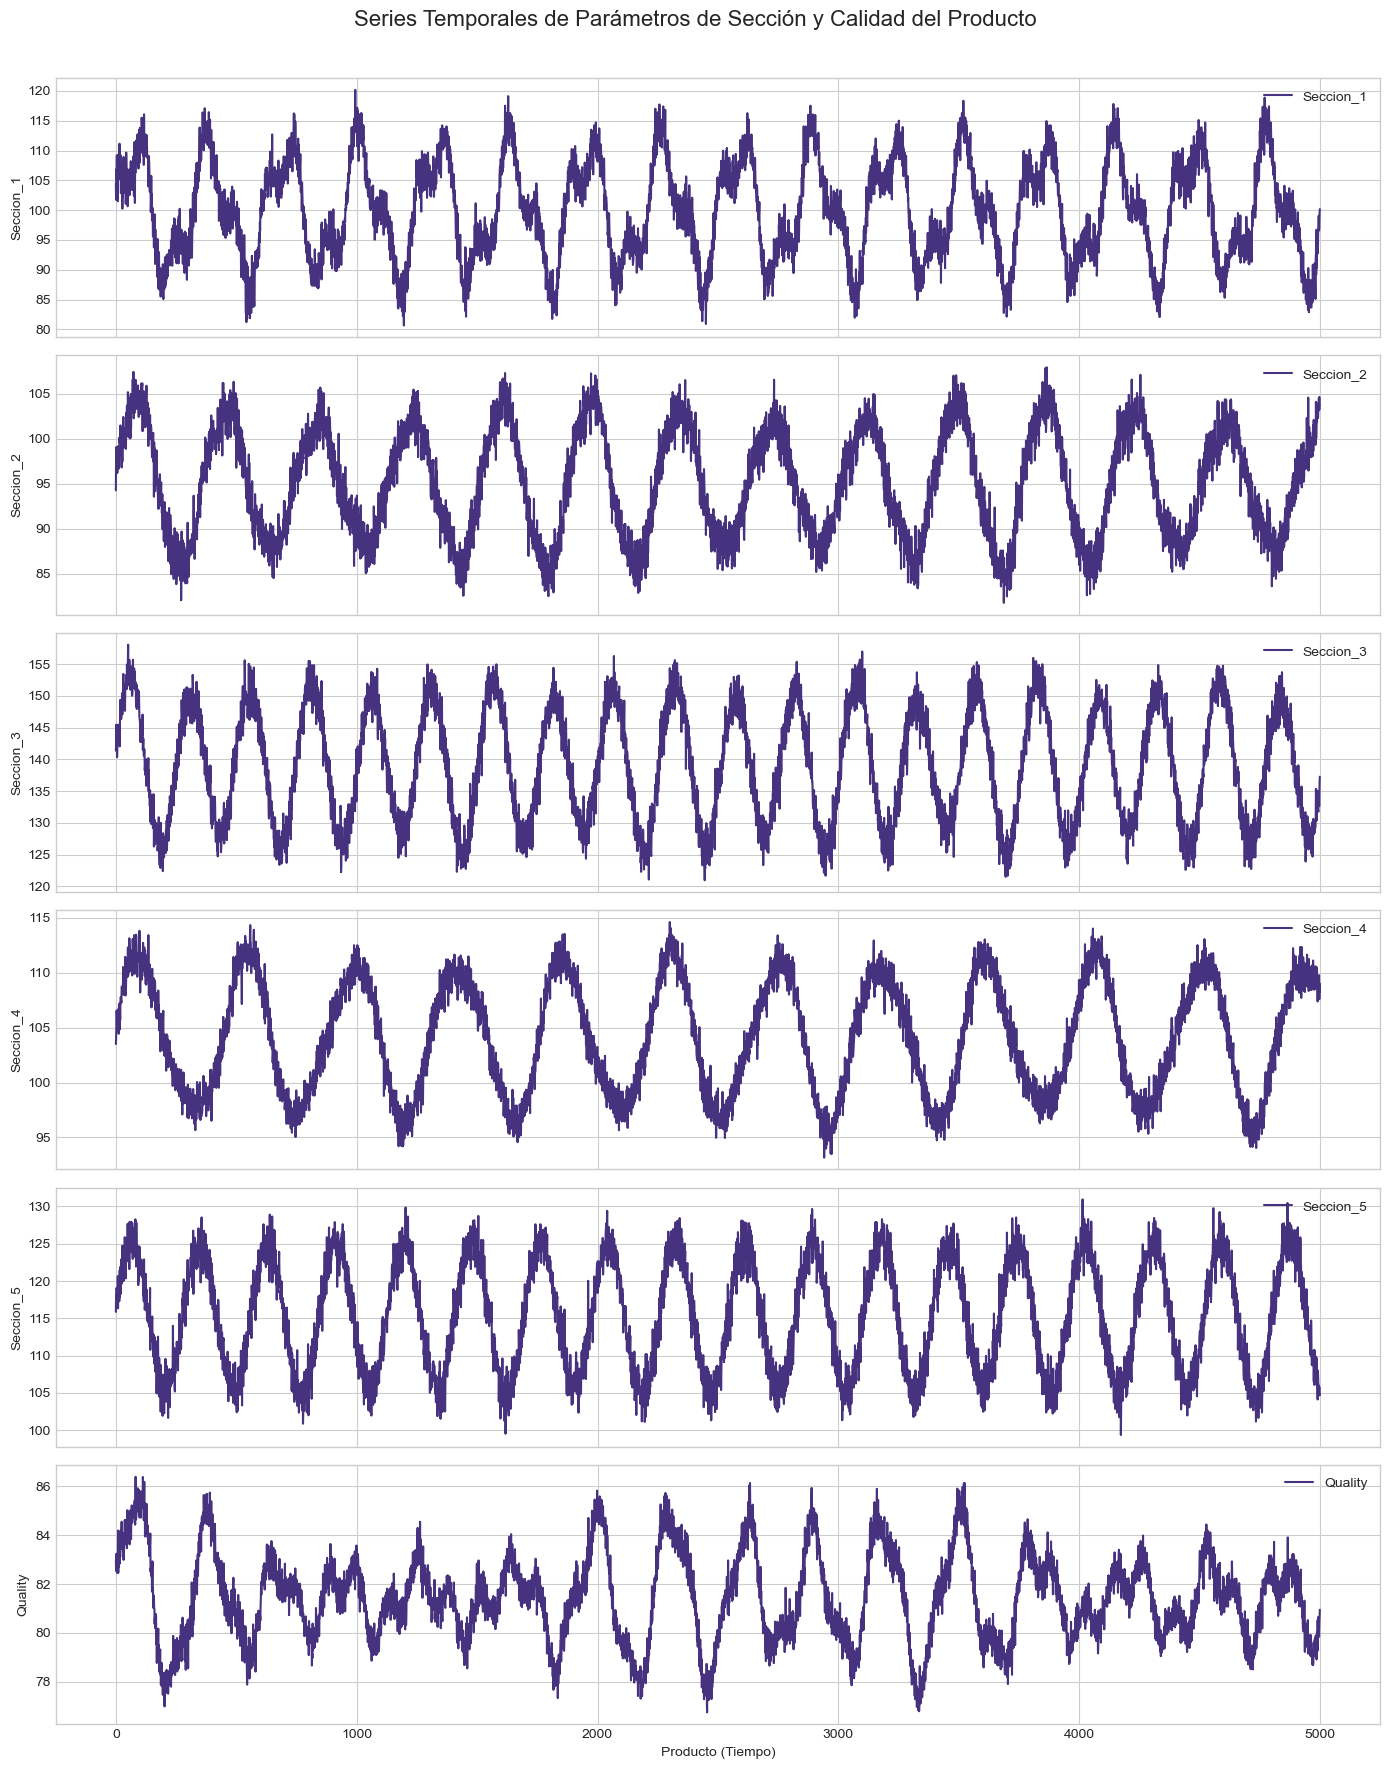

In [115]:
# ## 3. Exploración y Visualización de Datos
# Visualizar las series temporales generadas para entender sus patrones.

fig, axs = plt.subplots(N_SECTIONS + 1, 1, figsize=(14, 18), sharex=True)
features_to_plot = [f'Seccion_{s+1}' for s in range(N_SECTIONS)] + ['Quality']

for i, feature_name in enumerate(features_to_plot):
    axs[i].plot(data_df[feature_name], label=feature_name)
    axs[i].set_ylabel(feature_name)
    axs[i].legend(loc="upper right")
axs[-1].set_xlabel("Producto (Tiempo)")
fig.suptitle("Series Temporales de Parámetros de Sección y Calidad del Producto", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [116]:
# ## 4. Preprocesado de Datos

# **Características de entrada y variable objetivo**
# Características de entrada (X): S1_Param, S2_Param, S3_Param, S4_Param, S5_Param en el instante t.
# Variable objetivo (Y): Quality en el instante t+1 (Q_{t+1}).

feature_cols = [f'Seccion_{s+1}' for s in range(N_SECTIONS)]
target_col = 'Quality'

# Datos de entrada para la RNN (características de las N_SECTIONS secciones)
# Usaremos los datos hasta N_PRODUCTS_FINAL-1 para predecir la calidad desde el producto 1 hasta N_PRODUCTS_FINAL.
rnn_features = data_df[feature_cols].values[:-1] # Características X_0, ..., X_{N-2} (N = N_PRODUCTS_FINAL)
# Datos objetivo para la RNN (Calidad del producto en t+1)
rnn_targets = data_df[target_col].values[1:]   # Objetivos Y_1, ..., Y_{N-1}

print(f"Forma de rnn_features: {rnn_features.shape}")
print(f"Forma de rnn_targets: {rnn_targets.shape}")

Forma de rnn_features: (4999, 5)
Forma de rnn_targets: (4999,)


In [117]:
# **División en conjuntos de Entrenamiento, Validación y Prueba**
# Crucial: división cronológica para series temporales.
# 70% entrenamiento, 15% validación, 15% prueba.

num_train_samples = int(0.7 * len(rnn_features))
num_val_samples = int(0.15 * len(rnn_features))
num_test_samples = len(rnn_features) - num_train_samples - num_val_samples

train_features = rnn_features[:num_train_samples]
train_targets = rnn_targets[:num_train_samples]

val_features = rnn_features[num_train_samples : num_train_samples + num_val_samples]
val_targets = rnn_targets[num_train_samples : num_train_samples + num_val_samples]

test_features = rnn_features[num_train_samples + num_val_samples:]
test_targets = rnn_targets[num_train_samples + num_val_samples:]

print(f"Muestras de entrenamiento (features): {train_features.shape}")
print(f"Muestras de validación (features): {val_features.shape}")
print(f"Muestras de prueba (features): {test_features.shape}")


Muestras de entrenamiento (features): (3499, 5)
Muestras de validación (features): (749, 5)
Muestras de prueba (features): (751, 5)


In [118]:
# **Normalización de Características**
# Usar `Normalization` layer de Keras. Adaptar SOLO con datos de entrenamiento.

normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(train_features) # Adaptar SOLO con datos de entrenamiento (las 5 características)

# **Creación de Secuencias (Ventanas de Tiempo)**
# Usar `tf.keras.utils.timeseries_dataset_from_array`.
# La configuración `rnn_features` y `rnn_targets` (desplazados 1 paso) asegura que
# una secuencia de features `X_i, ..., X_{i+SL-1}` predice `Quality_{ (i+SL-1) + 1 } = Quality_{i+SL}`.
# Esto es correcto para predecir el siguiente valor de calidad tras la secuencia de entrada.
BATCH_SIZE = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=train_features,
    targets=train_targets,
    sequence_length=SEQUENCE_LENGTH,
    sampling_rate=1,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data=val_features,
    targets=val_targets,
    sequence_length=SEQUENCE_LENGTH,
    sampling_rate=1,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data=test_features,
    targets=test_targets,
    sequence_length=SEQUENCE_LENGTH,
    sampling_rate=1,
    batch_size=BATCH_SIZE,
    shuffle=False,
)


print("\nInspección de un lote del dataset de entrenamiento:")
for batch_inputs, batch_targets in train_dataset.take(1):
    print("Forma de las entradas del lote (batch_inputs):", batch_inputs.shape) # (BATCH_SIZE, SEQUENCE_LENGTH, N_SECTIONS)
    print("Forma de las etiquetas del lote (batch_targets):", batch_targets.shape) # (BATCH_SIZE,)


Inspección de un lote del dataset de entrenamiento:
Forma de las entradas del lote (batch_inputs): (32, 5, 5)
Forma de las etiquetas del lote (batch_targets): (32,)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_8 (Normalization) │ (None, 5, 5)           │            11 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_quality (Dense)          │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,556 (17.80 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 11 (48.00 B)

Epoch 1/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4564.2231 - mean_absolute_error: 61.5502 - val_loss: 92.6251 - val_mean_absolute_error: 7.7354
Epoch 2/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146.3581 - mean_absolute_error: 9.5164 - val_loss: 78.6033 - val_mean_absolute_error: 7.2582
Epoch 3/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109.1573 - mean_absolute_error: 8.2200 - val_loss: 62.1606 - val_mean_absolute_error: 6.4780
Epoch 4/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82.0551 - mean_absolute_error: 7.1354 - val_loss: 46.9087 - val_mean_absolute_error: 5.6602
Epoch 5/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60.5415 - mean_absolute_error: 6.1114 - val_loss: 35.5863 - val_mean_absolute_error: 4.9290
Epoch 6/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.6200 - mean_absolute_error: 5.0509 - val_loss: 26.6966 - val_mean_absolute_error: 4.3149
Epoch 7/1000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.0937 -

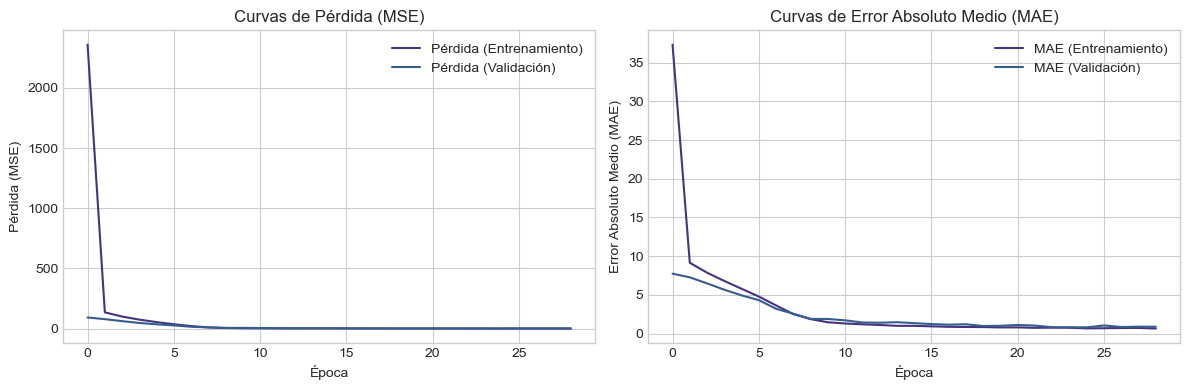

In [119]:
# ## 5. Definición del Modelo RNN
# Modelo secuencial con: Input, Normalization, SimpleRNN, Dense (salida).

num_model_features = train_features.shape[1] # Debería ser N_SECTIONS (5)

model = keras.Sequential([
    keras.layers.Input(shape=(SEQUENCE_LENGTH, num_model_features), name="input_sequence"),
    normalizer, # Capa de normalización adaptada
    keras.layers.SimpleRNN(units=64, activation='relu', name="simple_rnn"),
    keras.layers.Dense(units=1, name="output_quality") # Salida para regresión
])

model.summary()

# ## 6. Compilación del Modelo
# Optimizador Adam, pérdida MSE, métrica MAE.

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

# ## 7. Entrenamiento del Modelo
EPOCHS = 1000 # Aumentamos un poco por la posible mayor complejidad
# Considerar EarlyStopping en una implementación real.
callback_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5, # Número de épocas sin mejora antes de detener
    restore_best_weights=True # Restaurar los pesos del modelo de la mejor época
)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[callback_early_stopping] # Añadimos el callback
)

# ## 8. Evaluación del Modelo

# **Curvas de Aprendizaje**
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida (Entrenamiento)')
plt.plot(history.history['val_loss'], label='Pérdida (Validación)')
plt.title('Curvas de Pérdida (MSE)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='MAE (Entrenamiento)')
plt.plot(history.history['val_mean_absolute_error'], label='MAE (Validación)')
plt.title('Curvas de Error Absoluto Medio (MAE)')
plt.xlabel('Época')
plt.ylabel('Error Absoluto Medio (MAE)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8984 - mean_absolute_error: 0.7570 

Evaluación en el conjunto de prueba:
Pérdida (MSE) en prueba: 0.9185
Error Absoluto Medio (MAE) en prueba: 0.7647
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


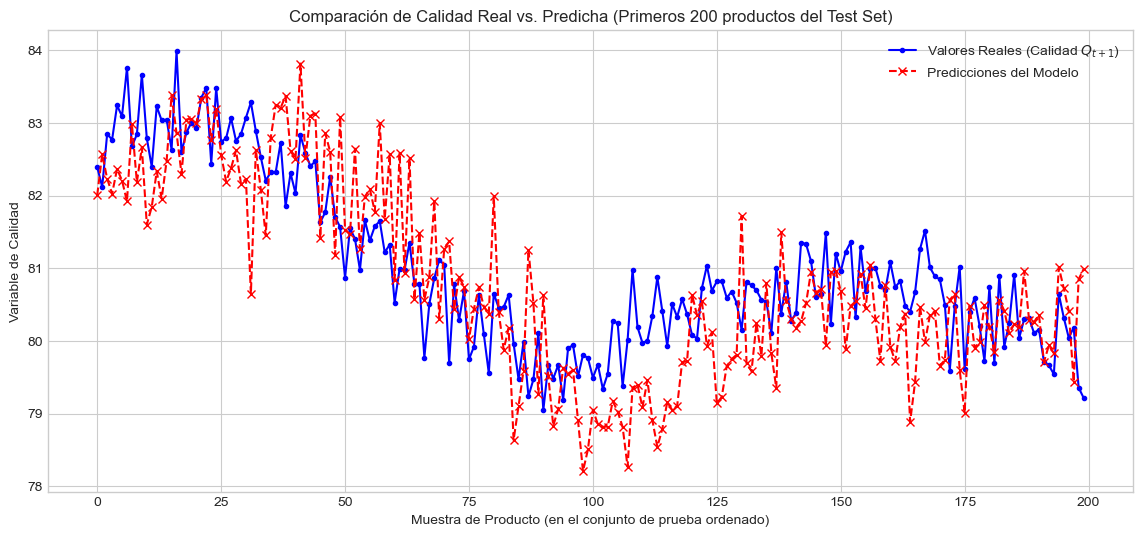

In [120]:
# **Evaluación sobre el Conjunto de Prueba**
test_loss, test_mae = model.evaluate(test_dataset)
print(f"\nEvaluación en el conjunto de prueba:")
print(f"Pérdida (MSE) en prueba: {test_loss:.4f}")
print(f"Error Absoluto Medio (MAE) en prueba: {test_mae:.4f}")
# *Comentario crítico:* El MAE en prueba nos da una idea de qué tan precisas son las predicciones
# en términos de la unidad de la variable de calidad. El valor aquí dependerá de la complejidad
# de las dependencias que el SimpleRNN pudo capturar.

# **Visualización de Predicciones vs. Valores Reales**
predictions = model.predict(test_dataset)

actual_targets_test_list = []
for _, batch_targets_test in test_dataset:
    actual_targets_test_list.append(batch_targets_test.numpy())
actual_targets_test = np.concatenate(actual_targets_test_list)

plot_range = min(200, len(actual_targets_test))

plt.figure(figsize=(14, 6))
plt.plot(actual_targets_test[:plot_range], label='Valores Reales (Calidad $Q_{t+1}$)', color='blue', marker='.', linestyle='-')
plt.plot(predictions[:plot_range, 0], label='Predicciones del Modelo', color='red', marker='x', linestyle='--')
plt.title(f'Comparación de Calidad Real vs. Predicha (Primeros {plot_range} productos del Test Set)')
plt.xlabel('Muestra de Producto (en el conjunto de prueba ordenado)')
plt.ylabel('Variable de Calidad')
plt.legend()
plt.grid(True)
plt.show()

